In [ ]:
# %pip install arch

In [64]:
import yfinance as yf
import arch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [6]:
TICKERS = ["AAPL", "MSFT", "TSLA", "JPM"]
START_DATE = date(2019, 1, 1)

In [8]:
raw_md_df = yf.download(
    TICKERS,
    start=START_DATE,
)

[*********************100%***********************]  4 of 4 completed


In [14]:
md_df = (
    raw_md_df[["Adj Close"]]
    .droplevel(0, axis=1)
    .melt(var_name="ticker", value_name="adj_close", ignore_index=False)
    .reset_index()
    .rename(columns={"Date": "date"})
    .set_index(["ticker", "date"])
    .sort_index()
)
md_df

adj_close
ticker date                   
AAPL   2018-12-31    38.282608
       2019-01-02    38.326290
       2019-01-03    34.508717
       2019-01-04    35.981865
       2019-01-07    35.901775
...                        ...
TSLA   2021-11-22  1156.869995
       2021-11-23  1109.030029
       2021-11-24  1116.000000
       2021-11-26  1081.920044
       2021-11-29  1136.989990

[2940 rows x 1 columns]

Once we have our price series, we calculate a volatility estimate using an ARCH model. This volatility is a "real-world" volatility under the physical probability measure. We will throw caution to the wind and use it in our calculations as a proxy for implied volatility (vol under the risk-neutral probability measure). The results will not be realistic but this is just to get some input to the model that looks a bit like the real deal.

In [71]:
def _calculate_vol_estimate(g):
    ret_s = 100 * g.pct_change().dropna()
    am = arch.arch_model(ret_s)
    res = am.fit(update_freq=5, disp=False)
    res_s = res.conditional_volatility / 100 * np.sqrt(252)  # annualize
    return res_s


vol_df = md_df.join(
    md_df.groupby(level="ticker")["adj_close"]
    .transform(_calculate_vol_estimate)
    .rename("vol")
)
vol_df

adj_close       vol
ticker date                             
AAPL   2018-12-31    38.282608       NaN
       2019-01-02    38.326290  0.470640
       2019-01-03    34.508717  0.430503
       2019-01-04    35.981865  0.729828
       2019-01-07    35.901775  0.704121
...                        ...       ...
TSLA   2021-11-22  1156.869995  0.634511
       2021-11-23  1109.030029  0.607280
       2021-11-24  1116.000000  0.622948
       2021-11-26  1081.920044  0.593477
       2021-11-29  1136.989990  0.593619

[2940 rows x 2 columns]

<AxesSubplot:xlabel='date', ylabel='vol'>

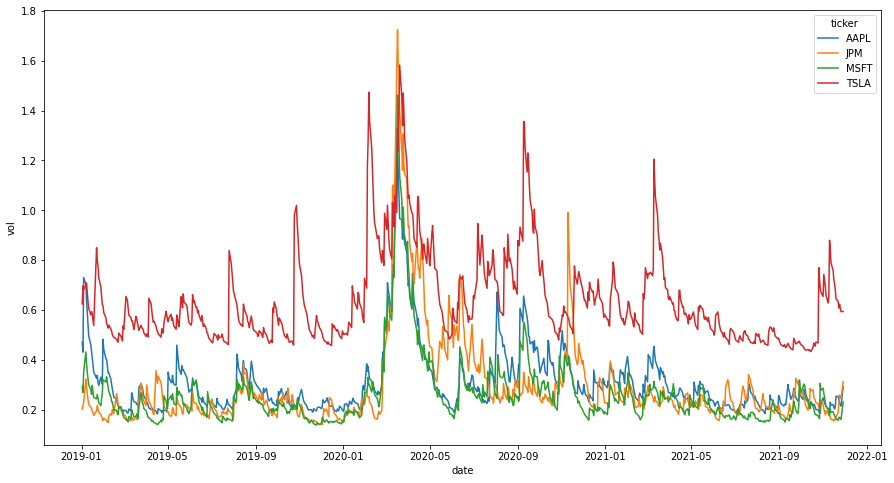

In [72]:
plt.figure(figsize = (15,8))
sns.lineplot(y="vol", x="date", data=vol_df.reset_index(), hue="ticker")

In [75]:
vol_df.rename(columns={"adj_close": "spot"}).dropna().to_csv("market_data.csv")